In [187]:
# import useful packages
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import model
import imp

imp.reload(model)


# set pandas display option
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# set device
device = torch.device('cuda')

In [188]:
"""
read data for train val test dataset separately
"""

def read_inputs(file_path, x1, x2, display_df=False, display_ls=False):

    inputs = pd.DataFrame()

    # read input yolo data
    for label_file in file_path.iterdir():
        # read labels
        df = pd.read_csv(label_file,sep=" ",names=['id','center-x','center-y','w','h'])

        image_type = str(label_file.name).split('_')

        df['picture'] = [int(image_type[0])] * len(df.index)

        if image_type[1] == "Screen1":
            df['screen'] = [1] * len(df.index)
        elif image_type[1] == "Screen2":
            df['screen'] = [2] * len(df.index)

        inputs = inputs.append(df, ignore_index=True)

    inputs = inputs.sort_values(by=["picture","id", "screen"]).reset_index(drop=True)

    if display_df:
        print(len(inputs))
        display(inputs)

    input_data = []

    for i in range(x1, x2 + 1):
        for j in range(0,4):
            for k in range(1,3):

                temp = inputs.loc[(inputs['picture'] == i) & (inputs['id'] == j) & (inputs['screen'] == k)].reset_index(drop=True)

                if len(temp.index) == 0:
                    temp1 = [0]
                elif len(temp.index) == 1:
                    temp1 = [temp.iloc[0]['center-x'], temp.iloc[0]['center-y'], temp.iloc[0]['w'], temp.iloc[0]['h']]
                else:
                    print("SOMETHING WRONG HAPPENS")
                    return

                input_data.append(temp1)
    if display_ls:
        print(len(input_data))
        display(input_data)

    return input_data

train_path = Path("../dataset/arms/labels/train")
val_path = Path("../dataset/arms/labels/val")
test_path = Path("../dataset/arms/labels/test")

train_x1 = read_inputs(train_path, 1, 200)
train_x2 = read_inputs(train_path, 301, 400)
train_x = train_x1 + train_x2

val_x = read_inputs(val_path, 201, 300)
test_x = read_inputs(test_path, 401, 500)

In [189]:
"""
read output data for train val and test
"""

def read_outputs(target_path, display_df=False, display_ls=False):

    outputs = pd.read_csv(target_path)
    outputs.columns = ["picture", "0.x", "0.z", "1.x", "1.z", "2.x", "2.z", "3.x", "3.z"]

    outputs_0 = outputs.loc[:,['picture','0.x','0.z']]
    outputs_0['id'] = [0] * len(outputs.index)
    outputs_0.columns = ['picture','x', 'z', 'id']

    outputs_1 = outputs.loc[:,['picture','1.x','1.z']]
    outputs_1['id'] = [1] * len(outputs.index)
    outputs_1.columns = ['picture','x', 'z', 'id']

    outputs_2 = outputs.loc[:,['picture','2.x','2.z']]
    outputs_2['id'] = [2] * len(outputs.index)
    outputs_2.columns = ['picture','x', 'z', 'id']

    outputs_3 = outputs.loc[:,['picture','3.x','3.z']]
    outputs_3['id'] = [3] * len(outputs.index)
    outputs_3.columns = ['picture','x', 'z', 'id']

    outputs = outputs_0.append(outputs_1, ignore_index=True).append(outputs_2, ignore_index=True).append(outputs_3, ignore_index=True).sort_values(by = ['picture','id']).reset_index(drop=True)

    if display_df:
        print(len(outputs))
        display(outputs)

    output_data = []

    for index, row in outputs.iterrows():
        output_data.append([row['x']/808, row['z']/450])
        output_data.append([row['x']/808, row['z']/450])

    if display_ls:
        print(len(output_data))
        display(output_data)

    return output_data

train_y = read_outputs("../dataset/arms/targets/train_gt_coordinates.csv")
val_y = read_outputs("../dataset/arms/targets/val_gt_coordinates.csv")
test_y = read_outputs("../dataset/arms/targets/test_gt_coordinates.csv")

In [190]:
def filter_data(x, y, display_ls=False):

    input_data = []
    output_data = []

    for i in range(len(x)):
        if x[i] != [0]:
            input_data.append(x[i])
            output_data.append(y[i])

    if display_ls:
        print("input_data",len(input_data), sep='\t')
        display(input_data)

        print("output_data",len(output_data), sep='\t')
        display(output_data)

    return input_data, output_data

train_x, train_y = filter_data(train_x, train_y)
val_x, val_y = filter_data(val_x, val_y)
test_x, test_y = filter_data(test_x, test_y)

In [191]:
def get_tensor(inputs, outputs):
    input_data = torch.tensor(inputs, dtype=torch.float32).to(device)
    output_data = torch.tensor(outputs, dtype=torch.float32).to(device)

    torch.manual_seed(seed=1)

    torch_dataset = TensorDataset(input_data, output_data)

    return torch_dataset

train = get_tensor(train_x, train_y)
val = get_tensor(val_x, val_y)

In [192]:
weight_path = "./weights/direct_regress.pth"

# batch size = 6
train = DataLoader(train, batch_size=6, shuffle=True)

train_loss, val_loss = model.train(1e-5, 300, train, val, weight_path)

0/300	train_loss	0.3134754195055935	val_loss	0.2509779632091522
Model has been saved!
----
1/300	train_loss	0.25495703610476483	val_loss	0.20472782850265503
Model has been saved!
----
2/300	train_loss	0.19328028563242616	val_loss	0.1569901406764984
Model has been saved!
----
3/300	train_loss	0.13263592464074994	val_loss	0.11835867166519165
Model has been saved!
----
4/300	train_loss	0.08912284278802657	val_loss	0.09631925076246262
Model has been saved!
----
5/300	train_loss	0.06746806408372823	val_loss	0.08894798159599304
Model has been saved!
----
6/300	train_loss	0.060891690548886074	val_loss	0.08759334683418274
Model has been saved!
----
7/300	train_loss	0.05939359821672185	val_loss	0.08745504915714264
Model has been saved!
----
8/300	train_loss	0.05907792747125364	val_loss	0.08782217651605606
----
9/300	train_loss	0.05894776365688343	val_loss	0.0879233106970787
----
10/300	train_loss	0.05892929302402929	val_loss	0.08797018975019455
----
11/300	train_loss	0.058902350583982264	val_lo

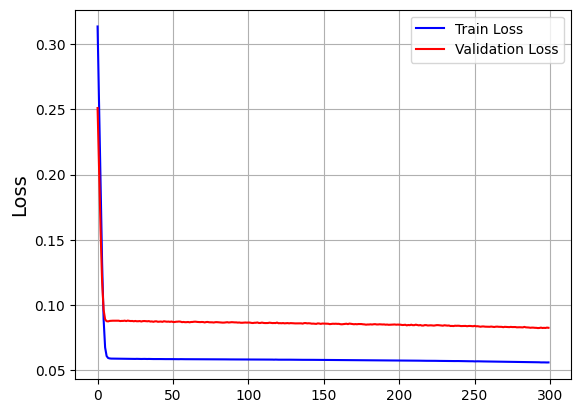

In [195]:
import matplotlib.pyplot as plt

Data = {'Train Loss': train_loss,
        'Validation Loss': val_loss}

df = pd.DataFrame(Data)

plt.plot(df['Train Loss'], color='blue', label = "Train Loss")
plt.plot(df['Validation Loss'], color='red', label = "Validation Loss")
# plt.title('Unemployment Rate Vs Year', fontsize=14)
# plt.xlabel('Loss', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()